<a href="https://colab.research.google.com/github/acastellanos-ie/ML2-MBD-EN-OCT-2021-S-1/blob/main/feature_engineering_practice/Practice%20Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [ ]:
repository_name = "ML2-MBD-EN-OCT-2021-S-1"
repository_url = 'https://github.com/acastellanos-ie/' + repository_name

In [ ]:
! git clone $repository_url

Install the requirements

In [ ]:
! pip install -Uqqr $repository_name/requirements.txt

Everything is set up properly! You can now move on to the practice code.

I do recommend you to restart the environment at this point to ensure that Google Colab is aware of the installed packages and their configuration (see image below).

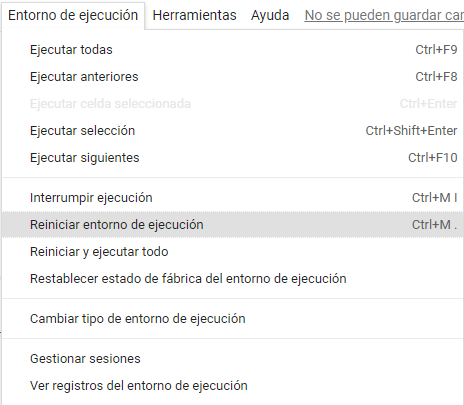

# Feature Engineering Practice

Go to the practice directory



In [ ]:
%cd $repository_name/feature_engineering_practice

The following code includes some imports and configuration steps for better visualization

In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') # Do not print warning messages

# Introduction

We will first contact the featuring engineering process and its impact in an ML pipeline in this first practice session.
Feature engineering is one of the essential steps of the process of developing prediction models. It is considered, by many authors, an art, and it involves human-driven design and intuition. This practice will try to uncover the most relevant issues that must be addressed and provide some guidelines to start building sound feature engineering processes for ML problems. 

The experimental dataset we are going to use is the HR Analytics Dataset. It includes explanatory variables of around 15k employees of a large company. The goal of the case study is to
model the probability of attrition (employees leaving, either on their own or because they got fired) of each employee and understand which variables are the most important ones and need to be addressed right away.

The results obtained will be helpful for the management to understand what changes they should make to their workplace to get most of their employees to stay.

For more details on the dataset and the task, see <https://www.kaggle.com/manojvijayan/feature-engineering-for-logistic-regression>.

# Data Loading and Pre-Processing

Let's load the dataset to make sense of the information we have about the employees.

In [ ]:
import pandas as pd
import numpy as np
import sklearn

In [ ]:
initial_hr_df = pd.read_csv("data/turnover.csv")
initial_hr_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [ ]:
# Keep the original dataset for later comparisons and make a copy for the FE process
hr_df = initial_hr_df

We have 10 columns: the target variable (`left`) and 9 more features to work with. Let's analyze a little bit more each of them to check if we need to clean or preprocess them.

Let's inspect the dataset in more detail with `pandas_profiling`.

In [ ]:
from pandas_profiling import ProfileReport
report = ProfileReport(hr_df, minimal=False)
report

## Factorize Features

2 of the categories (`sales` and `salary`) are categorical. In addition, if we analyze the rest of the features we will see that we have three more categorical values encoded as numeric: `Work_accident`, `promotion_last_5years` and the target variable itself (`left`). Therefore, we should convert them to categorical before any further processing.

You can use the `astype` function for the conversion.

In [ ]:
hr_df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [ ]:
hr_df['sales'] = hr_df.sales.astype('category')
hr_df['salary'] = hr_df.salary.astype('category')
hr_df['promotion_last_5years'] = hr_df.promotion_last_5years.astype('category')
hr_df['left'] = hr_df.left.astype('category')
hr_df['Work_accident'] = hr_df.Work_accident.astype('category')

hr_df.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident            category
left                     category
promotion_last_5years    category
sales                    category
salary                   category
dtype: object

### Advanced Factorization

The rest of the numerical values present a level of detail that may be much more fine-grained than we need. For instance, the satisfaction level can be represented by different categories (low, medium, high, ...). This process is usually refered as bucketization or discretization. We will then create another "bucketized" feature for each of the numerical columns.

sklearn provides 2 main ways of doing it: the [`KBinsDiscretizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer) and the [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) (for more details, please refer to the oficial documentation: https://scikit-learn.org/stable/modules/preprocessing.html#discretization).

The following piece of code is just a demonstrative example of how to do this process by appyling both methods (i.e., one to transform the `satisfaction_level` and the other one to transform the `last_evaluation` feature). The values that I've selected for the bucketization are arbitrary. In a real example, you should either find the optimal configuration or rely on some business knowledge to define these values. 


In [ ]:
from sklearn.preprocessing import FunctionTransformer

bins=[0, 0.11, 0.35, 0.46, 0.71, 0.92,1.0]
labels=[0,1,2,3,4,5]

transformer = FunctionTransformer(
    pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False}
)

hr_df['satisfaction_level_bin'] = transformer.fit_transform(hr_df['satisfaction_level'])

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

hr_df['last_evaluation_bin'] = KBinsDiscretizer(n_bins=[6], encode='ordinal').fit_transform(hr_df[['last_evaluation']])

Although not exactly discretization, the following code transform the `number_project` and the `time_spend_company` features to make them more readable. Additionally, we are collapsing some of the values (e.g., both 6 and 7 are encoded as `High`), the main aim is to provide a better understanding of the feature values.

In [ ]:
hr_df['number_project_cat'] = hr_df['number_project'].map({2:"Low",3:"Low",4:"Medium",5:"Medium",6:"High",7:"Very_High"}).astype('category')
hr_df['time_spend_company_cat'] = hr_df['time_spend_company'].map({2:"Low",3:"Medium",4:"Medium",5:"Medium",6:"High",7:"High",8:"Very_High",10:"Very_High"}).astype('category')

## Hunting NAs

There is not any NULL values, so we can skip this step.

In [ ]:
hr_df.isnull().sum()

satisfaction_level        0
last_evaluation           0
number_project            0
average_montly_hours      0
time_spend_company        0
Work_accident             0
left                      0
promotion_last_5years     0
sales                     0
salary                    0
satisfaction_level_bin    0
last_evaluation_bin       0
number_project_cat        0
time_spend_company_cat    0
dtype: int64

As we have some categorical values with strings, we need to encode them to apply the sklearn classifiers. Let's apply what we learned in the previous practice

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

X = hr_df.drop(['left'], axis=1)
y = hr_df['left']

# Define what is a categorical feature (the type of the feature is equal to object)
categorical = hr_df.columns[hr_df.dtypes=='category'].tolist()
categorical.remove('left')
numerical = hr_df.columns[hr_df.dtypes!='category'].tolist()

# Create a column transformer to define different transformations for each column
column_transformer = make_column_transformer(
    (MinMaxScaler(), numerical), # StandardScaler for non-categorical features
    (OneHotEncoder(handle_unknown='ignore'), categorical)) # OneHotEncoder for the categorical features (the handler_unknown param avoids future errors if a new category appears)

dummified_hr_df = pd.DataFrame(
    column_transformer.fit_transform(X), # use the column transformer to perform the encoding
    columns=[numerical + column_transformer.named_transformers_['onehotencoder'].get_feature_names(categorical).tolist()] # new feature names = numerical feature names + one-hot encoded feature names
)
dummified_hr_df.head(5)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,last_evaluation_bin,Work_accident_0,Work_accident_1,promotion_last_5years_0,promotion_last_5years_1,...,satisfaction_level_bin_4,satisfaction_level_bin_5,number_project_cat_High,number_project_cat_Low,number_project_cat_Medium,number_project_cat_Very_High,time_spend_company_cat_High,time_spend_company_cat_Low,time_spend_company_cat_Medium,time_spend_company_cat_Very_High
0,0.318681,0.265625,0.0,0.285047,0.125,0.2,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.780220,0.781250,0.6,0.775701,0.500,0.8,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.021978,0.812500,1.0,0.822430,0.250,0.8,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.692308,0.796875,0.6,0.593458,0.375,0.8,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.307692,0.250000,0.0,0.294393,0.125,0.2,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Feature Engineering

We first fit a linear model to the initial dataset to have a baseline to evaluate the data cleaning and feature engineering impact.

To facilitate the training process, we will use the `sklearn` library <https://scikit-learn.org/stable/index.html> that provides a wrapper for the preprocessing, training, and evaluation of many machine learning algorithms. 

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
print("Baseline model with Accuracy = {:.4}".format(np.mean(cross_val_score(initial_lm_mod, dummified_hr_df, y, cv=5))))


Baseline model with Accuracy = 0.9387


Sklearn does not provide a handy way to plot the feature importance of the LogisticRegression models. We can work it out by extracting the values of the logreg coefficients. (Code taken from: https://stackoverflow.com/a/47191103)

In [ ]:
def get_feature_importance(clf, feature_names):
    """
    Function to print the most important features of a logreg classifier based on the coefficient values
    """
    return pd.DataFrame({'variable': feature_names, # Feature names
                         'coefficient': clf.coef_[0] # Feature Coeficients
                    }) \
    .round(decimals=2) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['red', 'green'], align='zero')

In [ ]:
get_feature_importance(initial_lm_mod.fit(dummified_hr_df,y), dummified_hr_df.columns.get_level_values(0).tolist())

,variable,coefficient
32,number_project_cat_Very_High,14.000000
23,satisfaction_level_bin_0,13.010000
4,time_spend_company,10.610000
1,last_evaluation,6.190000
35,time_spend_company_cat_Medium,5.100000
34,time_spend_company_cat_Low,4.260000
25,satisfaction_level_bin_2,3.360000
33,time_spend_company_cat_High,2.590000
3,average_montly_hours,1.830000
0,satisfaction_level,0.240000


The analysis of the confusion matrix points out some interesting aspects:
  
 - We have an accuracy larger than 90%, which seems a good result to be reported to the HR department.
 
 - We are better at predicting the negative class (a employee is NOT going to leave the company) than the positive class (an employee will leave the company).

## Feature Generation

At this stage, we focus on generating new features to extend the information contained in the dataset. To that end, we have 2 ways:

- **Manual Generation:** This is the most interesting method. It focuses on generating new features that encode aspects that we deem relevant for predicting the target variable. There is no guideline for this step beyond relying on your domain knowledge (i.e., as discussed in class, it could be your knowledge as an expert on the domain or the information provided by relevant stakeholders that you include in the process). For this dataset, it could make sense to: collect personal information about your employees (e.g., do they have children?); gather more information on the types of projects the employee has participated in, the salary... I leave it up to you to think about it, and I encourage you to codify them and see if you can improve the performance of your models!
- **Automatic Generation:** Beyond the process mentioned above, there are some ways in which you can automatically generate features. The idea is to create combinations of your features exhaustively. In this way, you can encode dependencies between them or include non-linear features in the model (i.e., by creating non-linear combinations of the features).

In the following code, I am going to focus on the latter. In particular, I am going to use the [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) slkearn transformer to generate these non-linear combinations of the features. This transformer generates high-order (e.g., the square of the feature value: $x^2$) and interaction ($feature_1$ multiplied by $feature_2$: $x_1*x_2$) terms. For more details, please refer to the documentation: https://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features.

The following snippet makes use of the `PolynomialFeatures` to generate the combinations of our original features.

The most important parameter to define is the `degree` of the combinations. If you pick a `degree=2` you will generate combinations up to the square of the feature values (e.g., $x_1^2$) and the combinations of 2 features (e.g., $x_1 * x_2$). A `degree=3` will generate features such as $x_1^3$ or $x_1*x_2*x_3$

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
poly_hr_df = pd.DataFrame(poly.fit_transform(dummified_hr_df))
poly_hr_df

,0,1,2,3,4,5,6,7,8,9,...,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001953
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015625
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052734
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001953
14995,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001953
14996,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001953
14997,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015625


One of the downsides of this approach, as you can see, is the massive number of features it generates. With a `degree=3` around 30-40 original features results in more than a thousand!

As you increase the `degree` it will result in more features.

Let see if, at least, this results in a better performance.

In [ ]:
initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
print("Baseline model with Accuracy = {:.4}".format(np.mean(cross_val_score(initial_lm_mod, poly_hr_df, y, cv=5))))

Baseline model with Accuracy = 0.9609


It does! This is somehow expected. By creating non-linear combinations of the features, even simple linear models (such as Logistic Regression) can create non-linear solutions, solving complex problems.

Although this approach was a big thing in the early ages of machine learning, it is not so used anymore. There are several reasons for it. The first one is that it increases the complexity of the model by generating many features. On top of that, most of the feature combinations are not relevant, so you will add many irrelevant features to your dataset (the following Feature Selection process can mitigate this problem). Another reason is that nowadays, we have better methods to model these non-linearities. I am thinking specifically of deep learning methods. Deep Neural Nets can find complex non-linear features combinations that are informative for the target variable.

For the following process, I will not make use of these polynomial features to avoid overcomplicating the solution. Nevertheless, I do recommend you to experiment with them.

## Filtering Methods


We will rank the features according to their predictive power by applying the methodologies seen in class: the Chi Squared Independence test and the Information Gain.

### Chi-squared Selection
Making use of the [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) function rank the features according to the Chi Squared value. 

Does it make sense to remove some features? If so, do it!

We will start by applying the `SelectKBest` method with the `chi2` score function. This method will give a score to each feature according to its importance for predicting the target variable. 


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Apply ChiSquared to score the features based on the training data.
chi2_selector = SelectKBest(score_func=chi2).fit(dummified_hr_df,y)

Let's inspect what are the most important features according to ChiSquared. To that end, we need to sort the features according to the score assigned by the `chi2_selector`.

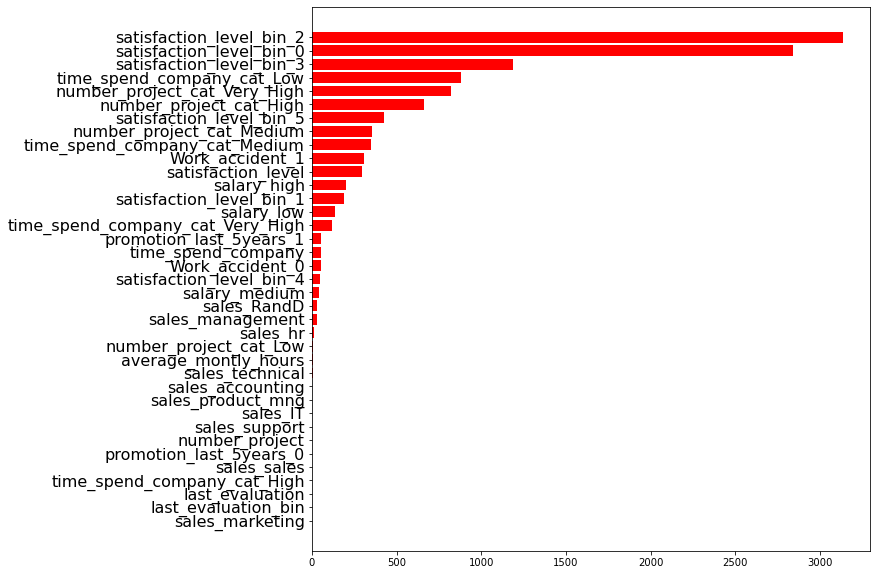

In [ ]:
# Sort the features according to the ChiSquared Scores
indices = np.argsort(chi2_selector.scores_)[::-1]

# Get the Features Names of the ordered Features
chi2_features = []
for i in range(len(dummified_hr_df.columns.get_level_values(0))):
    chi2_features.append(dummified_hr_df.columns.get_level_values(0)[indices[i]])

# Now plot
plt.figure(figsize=(10,10))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(chi2_features, chi2_selector.scores_[indices[range(len(dummified_hr_df.columns.get_level_values(0)))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

This figure will allow you to inspect the feature importance according to ChiSquared. 

With this information, you can now:

- Better understand the data and how it relates to the prediction problem.
- Validate any assumption you had on the data.
- Report this information to the relevant stakeholders.

I leave to you the exercise of analyzing the results in more detail. However, at first sight, we can see that aspects such as the time spent in the company and the number of projects in which you participate appear to be strongly relevant for the employee churning. Interestingly, they seem to be more important than the salary.

As a next exercise, we are going to try to find the optimal number of features. To that end, we will start by creating a model with only the most relevant feature, then another model with the two most relevant features, and so on. This procedure is similar to the stepwise methodologies that we presented in class.

(**Note:** This is not the only way of performing the feature selection. For example, you could decide to remove the features with a score equals to 0 (i.e., they are not impacting the values of the target variable). Or perhaps you can share this info with the HR team and decide the features you want to include in the model.)

In [ ]:
accuracy = []
for i in range(1,len(chi2_features)):
    accuracy.append(np.mean(cross_val_score(linear_model.LogisticRegression(max_iter=1000, penalty='none'), dummified_hr_df[chi2_features[:i]], y, cv=5)))


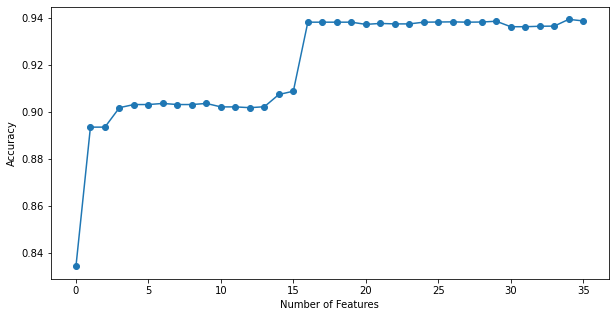

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(accuracy, 'o-')
plt.ylabel("Accuracy")
plt.xlabel("Number of Features");

As you can see around 17 features we achieved our optimal model.

In [ ]:
chi2_features[:17]

['satisfaction_level_bin_2',
 'satisfaction_level_bin_0',
 'satisfaction_level_bin_3',
 'time_spend_company_cat_Low',
 'number_project_cat_Very_High',
 'number_project_cat_High',
 'satisfaction_level_bin_5',
 'number_project_cat_Medium',
 'time_spend_company_cat_Medium',
 'Work_accident_1',
 'satisfaction_level',
 'salary_high',
 'satisfaction_level_bin_1',
 'salary_low',
 'time_spend_company_cat_Very_High',
 'promotion_last_5years_1',
 'time_spend_company']

Train a new model using only the selected features and evaluate its performance

In [ ]:
chi2_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
print("Accuracy = {:.4}".format(np.mean(cross_val_score(chi2_initial_lm_mod, dummified_hr_df[chi2_features[:17]], y, cv=5))))

Accuracy = 0.9381


In [ ]:
get_feature_importance(chi2_initial_lm_mod.fit(dummified_hr_df[chi2_features[:17]],y), dummified_hr_df[chi2_features[:17]].columns.get_level_values(0).tolist())

,variable,coefficient
1,satisfaction_level_bin_0,30.390000
4,number_project_cat_Very_High,22.280000
16,time_spend_company,10.820000
0,satisfaction_level_bin_2,3.950000
8,time_spend_company_cat_Medium,2.510000
3,time_spend_company_cat_Low,1.570000
13,salary_low,0.540000
10,satisfaction_level,0.340000
7,number_project_cat_Medium,0.170000
5,number_project_cat_High,-1.290000


Since the performance is better than the one of the original model, I will use this reduce version of the datase from now on.

In [ ]:
dummified_hr_df = dummified_hr_df[chi2_features[:17]]

## Embedded

Finally, we will experiment with embedded methods. If you remember from class, these methods focused on applying a regularization penalty to the model complexity. Utilizing this regularization, you can force the model to reduce the attention that it is paying to less relevant features. 

### Ridge

We will start with Ridge (or L2) regularization.

For this exercise, we are going to make use of the Ridge Model in sklearn <https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification>.

In [ ]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
print("Accuracy = {:.4}".format(np.mean(cross_val_score(ridge_mod, dummified_hr_df, y, cv=5))))

Accuracy = 0.9317


In [ ]:
get_feature_importance(ridge_mod.fit(dummified_hr_df,y), dummified_hr_df.columns.get_level_values(0).tolist())

,variable,coefficient
16,time_spend_company,8.750000
1,satisfaction_level_bin_0,6.030000
4,number_project_cat_Very_High,4.300000
0,satisfaction_level_bin_2,3.210000
8,time_spend_company_cat_Medium,2.020000
3,time_spend_company_cat_Low,0.720000
13,salary_low,0.520000
7,number_project_cat_Medium,0.230000
10,satisfaction_level,-0.750000
5,number_project_cat_High,-0.940000


Similar performance w.r.t the un-regularized models.

Let's look at how the coefficient weights and accuracy scores change along with the different regularization values.
To that end, I have implemented the following piece of code. Do not be overwhelmed by it. It basically defines a list of regularization values to test and train a new Logistic Regression model for one of these regularization values. We keep track of the coefficient values and the accuracy of each of these models to plot them according to the defined regularization parameters.

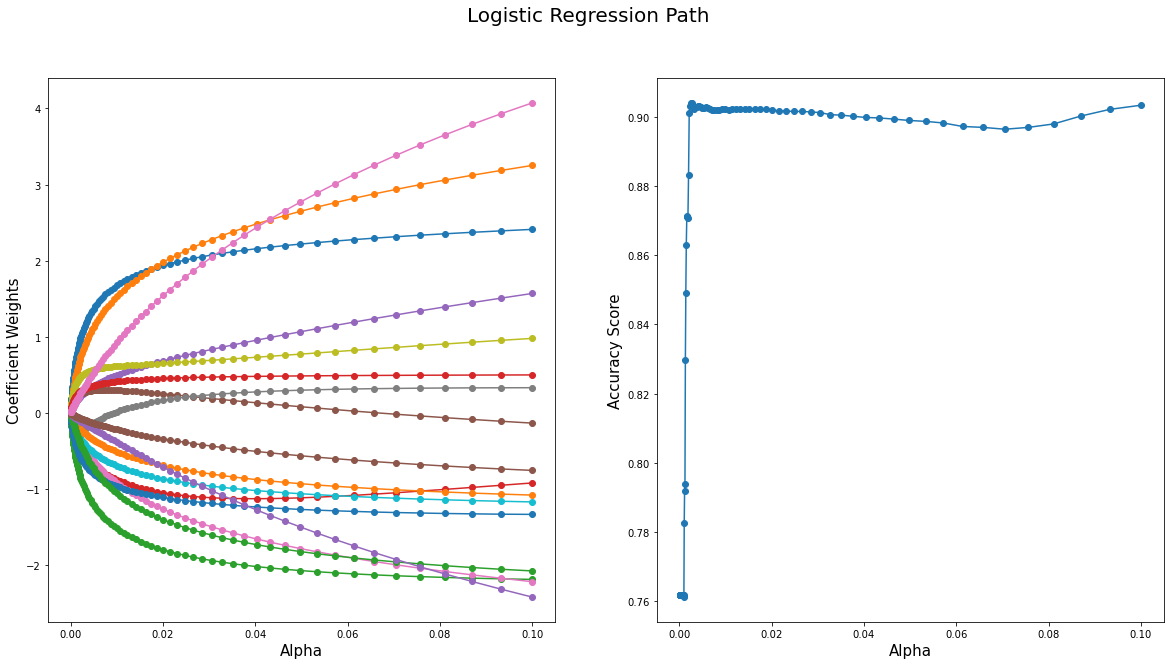

In [ ]:
# Define a basic Logisitic Regresion Model that applies L2 (Ridge) regularization
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')

# Define a list of 100 regularization values to test (from 0.1 to 0.0001)
alphas = 10**np.linspace(-1,-4,100)

coefs_ = [] # Array to store the value of the coefficients for each model
scores_ = [] # Array to store the accuracy for each model

# Go over the regularization values list defined above, train a logreg model for each of the regularization values and evaluate it.
for a in alphas:
    ridge_mod.set_params(C=a) # Set the regularization parameter 
    scores_.append(np.mean(cross_val_score(ridge_mod, dummified_hr_df, y, cv=5))) # Appends the accuracy of the model
    coefs_.append(ridge_mod.fit(dummified_hr_df, y).coef_.ravel().copy()) # Appends the coefficient of the model

# Conver the coefficient and scores arrays to numpy arrays
coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

# Define the figures to plot the values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

As you can see in the left figure, the smaller the alpha value (alpha), the larger the regularization and, consequently, the smaller the weights of the coefficients. This is because, if we check the sklearn documentation, we will see that this value is the: "*Inverse of regularization strength*."

When regularization is large enough (i.e., alpha is small), the values of the coefficients are close to 0 (i.e., null model).

 As there is a trade-off between variance (i.e., less over-fitted model --> more regularization) and bias (i.e., learning more from the training set --> less regularization), You must find the optimal alpha value. As you can see in the right figure, this value is achieved with small alpha values (i.e., more regularization). This specific value is not always the same since it depends on your data and the prediction problem. 

To automatize the process of finding the optimal value, you can make use of the LogisticRegressionCV function in sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) that performs CV, testing different hyperparameters (that you can provide) and selecting the optimal one. 

In [ ]:
from sklearn.feature_selection import SelectFromModel
alphas = 10**np.linspace(-1,-4,100)

ridge_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas)
print("Accuracy = {:.4}".format(np.mean(cross_val_score(ridge_mod_cv, dummified_hr_df, y, cv=5))))


Accuracy = 0.8977


We do not have many features, so the optimization of the alpha values does not provide a huge improvement. However, in scenarios with more complex datasets this procedure can significantly improve your model performance.

### Lasso

Let's see if Lasso (which actually removes features by making their coefficients equal to 0) improves the unregularized model.

In [ ]:
lasso_mod = linear_model.LogisticRegression(penalty='l1', solver='liblinear')
print("Accuracy = {:.4}".format(np.mean(cross_val_score(lasso_mod, dummified_hr_df, y, cv=5))))

Accuracy = 0.9361


In [ ]:
get_feature_importance(lasso_mod.fit(dummified_hr_df,y), dummified_hr_df.columns.get_level_values(0).tolist())

,variable,coefficient
16,time_spend_company,10.330000
1,satisfaction_level_bin_0,8.650000
4,number_project_cat_Very_High,6.660000
0,satisfaction_level_bin_2,3.740000
8,time_spend_company_cat_Medium,2.360000
3,time_spend_company_cat_Low,1.330000
13,salary_low,0.530000
7,number_project_cat_Medium,0.180000
10,satisfaction_level,0.000000
5,number_project_cat_High,-1.190000


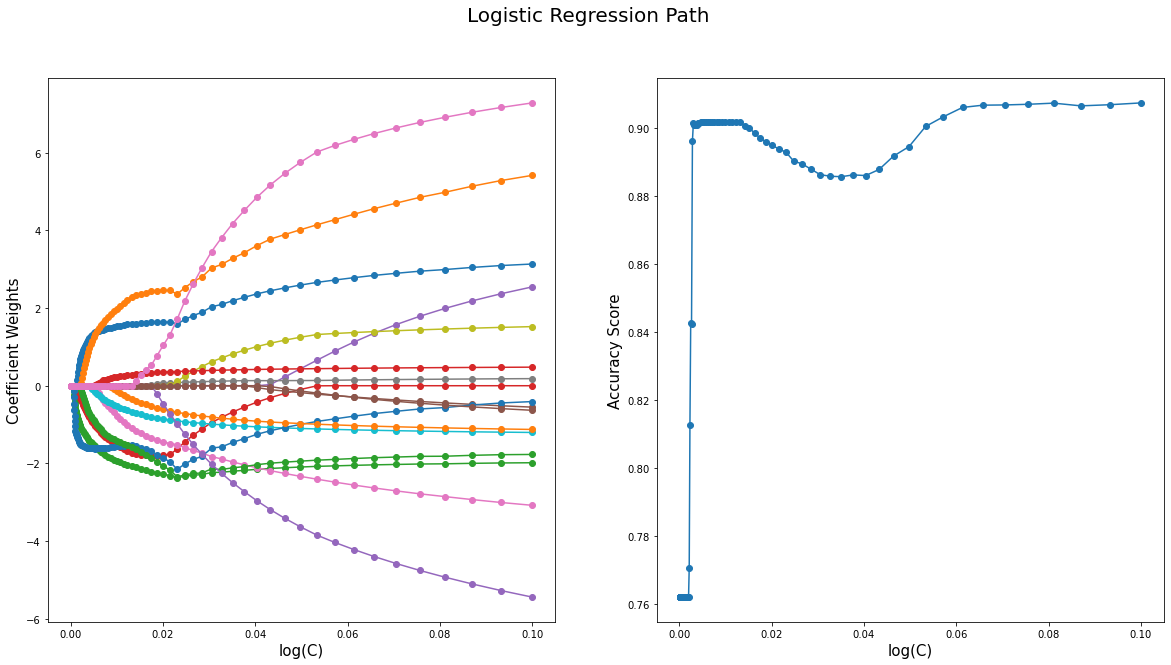

In [ ]:
lasso_mod = linear_model.LogisticRegression(penalty='l1',solver='liblinear')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    lasso_mod.set_params(C=a)
    scores_.append(np.mean(cross_val_score(lasso_mod, dummified_hr_df, y, cv=5))) # Appends the accuracy of the model
    coefs_.append(lasso_mod.fit(dummified_hr_df, y).coef_.ravel().copy()) # Appends the coefficient of the model

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('log(C)', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('log(C)', fontsize = 15)
ax2.axis('tight')

plt.show()

As can be seen in both graphs, Lasso regularization is more abrupt. If you remember from class, Lasso tries to nullify the coefficients (Ridge only tries to smooth their values). As a consequence, when regularization is large enough, many coefficient values are close to 0. You should be very careful when applying this regularization. If the regularization parameter is too restrictive, you will remove most of your features, and consequently, you'll ruin the performance of your model (as you can check in the right figure).

As with Rigde, you can use CV to find the optimal alpha value.

In [ ]:
from sklearn.feature_selection import SelectFromModel

lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l1',solver='liblinear',Cs=alphas)
print("Accuracy = {:.4}".format(np.mean(cross_val_score(lasso_mod_cv, dummified_hr_df, y, cv=5))))

Accuracy = 0.9075


Since Lasso is actually performing Feature Selection (i.e., it nullifies/removes unimportant features) you can apply the trained model to transform your dataset to keep only the features selected by Lasso

In [ ]:
lasso_mod_cv.fit(dummified_hr_df,y)
model = SelectFromModel(lasso_mod_cv, prefit=True)
X_new = model.transform(dummified_hr_df)
print("Original Number of Features = {} --> Number of features selected by Lasso = {}".format(dummified_hr_df.shape[1], X_new.shape[1]))

Original Number of Features = 17 --> Number of features selected by Lasso = 16


Lasso is not removing so many features since we did remove many of them in the ChiSquared selection. It explains why the results of both Lasso and Ridge are so similar.

Let's train a new model by just using these features.

In [ ]:
reduced_lasso_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l1', solver='liblinear')
print("Accuracy = {:.4}".format(np.mean(cross_val_score(reduced_lasso_mod, X_new, y, cv=5))))

Accuracy = 0.9372


In [ ]:
get_feature_importance(reduced_lasso_mod.fit(X_new,y), dummified_hr_df.columns[model.get_support()].get_level_values(0).tolist())

,variable,coefficient
15,time_spend_company,9.110000
1,satisfaction_level_bin_0,8.690000
3,number_project_cat_Very_High,6.840000
0,satisfaction_level_bin_2,3.700000
7,time_spend_company_cat_Medium,1.850000
12,salary_low,0.530000
6,number_project_cat_Medium,0.240000
9,satisfaction_level,0.000000
4,number_project_cat_High,-1.130000
8,Work_accident_1,-1.320000


Performance is quite similar, however, we have achieved it with almost half the features than with the original model. As discussed many times, models using less features are preferable: less complexity, less computation time, more explainable and less prone to over-fitting.